In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt

# Raman xaxis demo

This showcases basic tools for dealing with xaxis of Raman spectra.

## The *xaxis problem*

Spectrometers are basically camera sensors used in conjunction with a chromatic separation element (usually a diffraction grating). An alignment is made so that each camera pixel acquires intensity within a narrow wavelenght band. The *xaxis* is a list/vector that records the wavelenght (Raman shift) of each pixel of the sensor. The *xaxis problem* is that each spectrometer (and potentially acquisition) has it's own xaxis that must be determined in order to properly visualize spectra and compare acquisitions from different systems. There are usually two ways to do this;

1. Use a calibration source | This is usually the best method, but requires a good quality source with tunable emission wavelength for best results
1. Make an xaxis calibration acquisition on a reference sample | This is usually the chosen technique (and the one presented here)

## Model

xaxis [$cm^{-1}$] are well modeled by a $2^{nd}$ degree polynomial as

$$
\vec{x} = \begin{matrix}
              x_{1} \\
              x_{2} \\
              \vdots \\
              x_{n}
          \end{matrix}
$$

$$
x_i = c_0 + c_1 i + c_2 i^2
$$

where $i$ is the index of a pixel ($i \in [0, n-1]$) and $n$ is the number of camera pixel.

## xaxis unit

There are two useful units for xaxis

1. $nm$ | the natural units of a spectrometer
1. $cm^{-1}$ (read *inverse centimeter*) | the natural units of a Raman spectrum (Raman shift)

## In summary

1. The ramanTools convention is to use xaxis in $cm^{-1}$
1. xaxis [$cm^{-1}$] are modeled by a $2^{nd}$ degree polynomial
1. A spectrometer xaxis [$nm$] should not change much through time
    - xaxis can be used for troubleshooting because of this
1. Reference samples can be used to generate xaxis
    - We use **tylenol** and **nylon** for this purpose

## Reference material

Here are raman spectra of two reference material; tylenol and nylon.

Text(0, 0.5, 'I [au]')

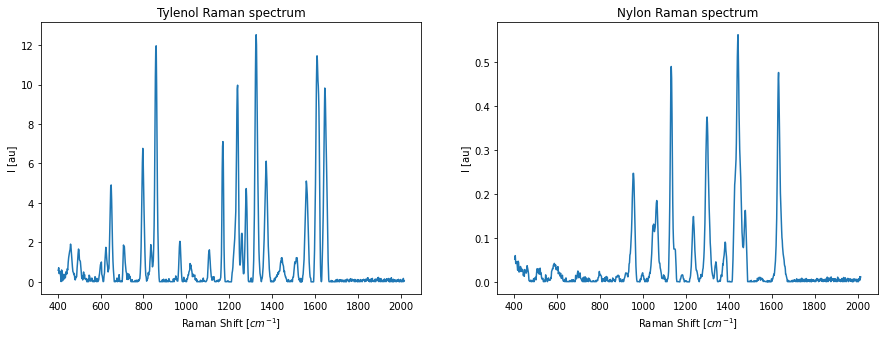

In [2]:
from orpl.calibration import nm2icm, icm2nm

# Loading reference tylenol
data = np.genfromtxt('data/samples/tylenol.csv', delimiter=',')

xaxis = data[1:, 0]
ref_tylenol_x = nm2icm(xaxis, 785)
ref_tylenol_r = data[1:, 2]

# Loading reference nylon
data = np.genfromtxt('data/samples/nylon.csv', delimiter=',')

xaxis = data[1:, 0]
ref_nylon_x = nm2icm(xaxis, 785)
ref_nylon_r = data[1:, 2]

plt.figure(figsize=[15, 5])
plt.subplot(1, 2, 1)
plt.plot(ref_tylenol_x, ref_tylenol_r)
plt.title('Tylenol Raman spectrum')
plt.xlabel('Raman Shift [$cm^{-1}$]')
plt.ylabel('I [au]')
plt.subplot(1, 2, 2)
plt.plot(ref_nylon_x, ref_nylon_r)
plt.title('Nylon Raman spectrum')
plt.xlabel('Raman Shift [$cm^{-1}$]')
plt.ylabel('I [au]')

## Unit conversion

RamanTools has two simple utility function to change the units of an xaxis between [$nm$] and [$cm^{-1}$]

- nm2icm | converts $nm \rightarrow cm^{-1}$
- icm2nm | converts $cm^{-1} \rightarrow nm$

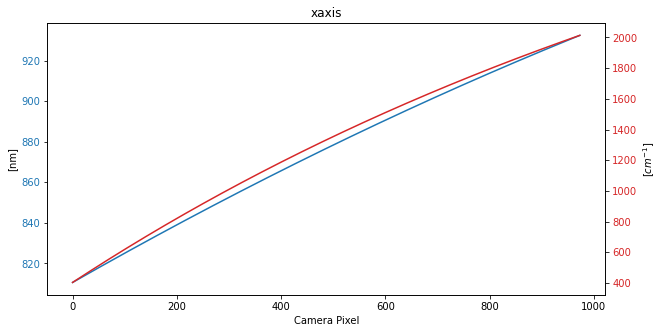

In [3]:
# Convert cm-1 to nm
tylenol_x_nm = icm2nm(ref_tylenol_x)

# Convert nm to cm-1
tylenol_x_icm = nm2icm(tylenol_x_nm)

# Plot results
fig, ax1 = plt.subplots(figsize=[10,5])
plt.title('xaxis')
ax2 = ax1.twinx()
ax1.plot(tylenol_x_nm, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlabel('Camera Pixel')
ax1.set_ylabel('[nm]')
ax2.plot(tylenol_x_icm, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylabel('[$cm^{-1}$]');

## Peak finding algorithm

All xaxis generation algorithms implemented in RamanTools heavily depend on automatic peak finding in Raman spectra. For this reason, an automatic peak finding algorithm has been implemented in RamanTools as the **auto_fpeak()** function.

**auto_fpeak()** uses `scipy.signal`'s `find_peaks()` *manual* peak finding function in conjunction with a bisection method to automatically find a specified number (*ntarget*) peaks.

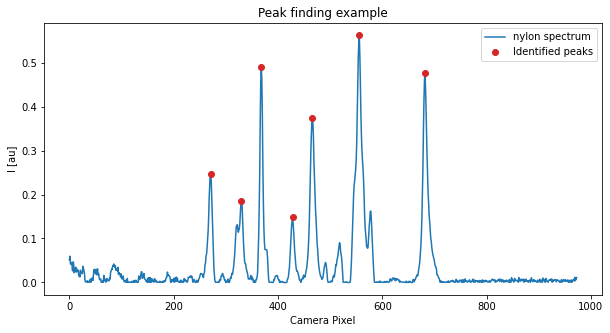

In [4]:
from orpl.calibration import find_npeaks
# fiding peaks for nylon
ntarget = 7
pid = find_npeaks(ref_nylon_r, ntarget)

plt.figure(figsize=[10, 5])
plt.title('Peak finding example')
plt.plot(ref_nylon_r, label='nylon spectrum')
plt.plot(pid, ref_nylon_r[pid], 'o', color='tab:red', label='Identified peaks')
plt.xlabel('Camera Pixel')
plt.ylabel('I [au]')
plt.legend()

## Xaxis generation algorithms

RamanTools has 3 different tools for the generation of xaxis.

### genx_fref()

This function generates an xaxis for a spectrum using a reference (measured on the same sample). Peak finding is used to find a specified number of peaks (npks) on both spectra and generates an xaxis to align them.

This example shows the process using a tylenol average spectrum acquired during the *bacon* acquisition and the tylenol spectrum already loaded as reference.

Text(0.5, 1.0, 'Experimental tylenol spectrum')

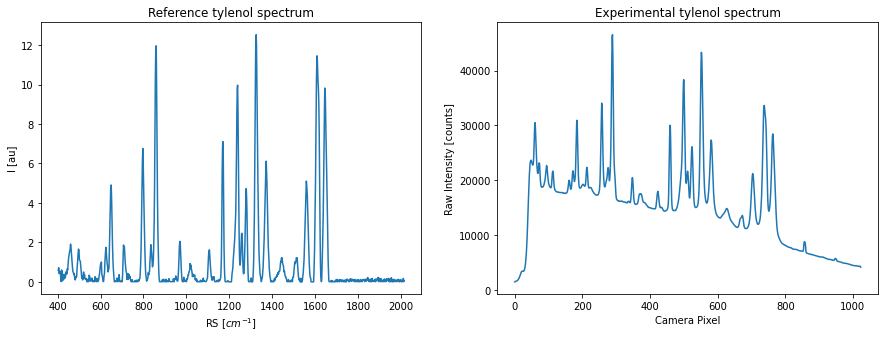

In [5]:
# Loading raw bacon experiment tylenol spectrum
data = json.load(open('data/samples/bacon/tylenol.json'))
exp_tylenol = np.stack(data[0]['RawSpectra'])
exp_tylenol = exp_tylenol.mean(axis=1)

plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.plot(ref_tylenol_x, ref_tylenol_r)
plt.xlabel('RS [$cm^{-1}$]')
plt.ylabel('I [au]')
plt.title('Reference tylenol spectrum')
plt.subplot(1,2,2)
plt.plot(exp_tylenol)
plt.xlabel('Camera Pixel')
plt.ylabel('Raw Intensity [counts]')
plt.title('Experimental tylenol spectrum')

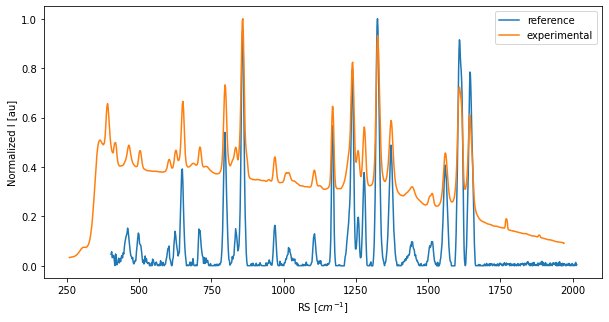

In [6]:
from orpl.calibration import xaxis_from_ref

# xaxis generation
xaxis = xaxis_from_ref(exp_tylenol, ref_tylenol_x, ref_tylenol_r, npks=7)

# Plotting result
plt.figure(figsize=[10,5])
plt.plot(ref_tylenol_x, ref_tylenol_r/ref_tylenol_r.max(), label='reference')
plt.plot(xaxis, exp_tylenol/exp_tylenol.max(), label='experimental')
plt.xlabel('RS [$cm^{-1}$]')
plt.ylabel('Normalized I [au]')
plt.legend()

### genx_fpks()
This function generates an xaxis for a spectrum using specified list of peak position [$cm^{-1}$]. This might be useful if you have theoretical/expected peak positions (from litterature for example).

This example shows the process using the same tylenol average spectrum as above, but the following peak positions;

pks_pos = [797, 859, 1170, 1238, 1325, 1608, 1644]

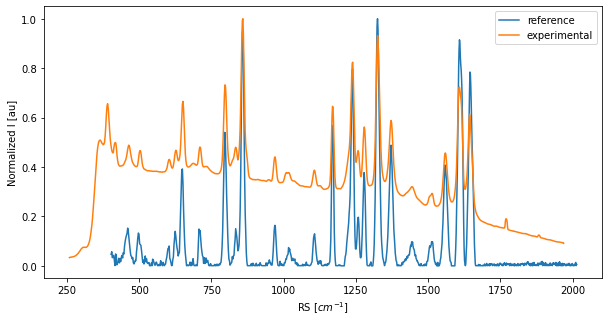

In [7]:
from orpl.calibration import xaxis_from_peaks

# xaxis generation
pks_pos = [797, 859, 1170, 1238, 1325, 1608, 1644]
xaxis, residual = xaxis_from_peaks(exp_tylenol, pks_pos)

# Plotting result
plt.figure(figsize=[10,5])
plt.plot(ref_tylenol_x, ref_tylenol_r/ref_tylenol_r.max(), label='reference')
plt.plot(xaxis, exp_tylenol/exp_tylenol.max(), label='experimental')
plt.xlabel('RS [$cm^{-1}$]')
plt.ylabel('Normalized I [au]')
plt.legend()

### autogenx()
This function generates an xaxis for a spectrum using a predefined **preset**. Although limitted to implemented presets, this is the most automated method.

Presets implemented at the moment of writing this are
- nylon
- tylenol

A synthetic nylon spectrum is used as an example

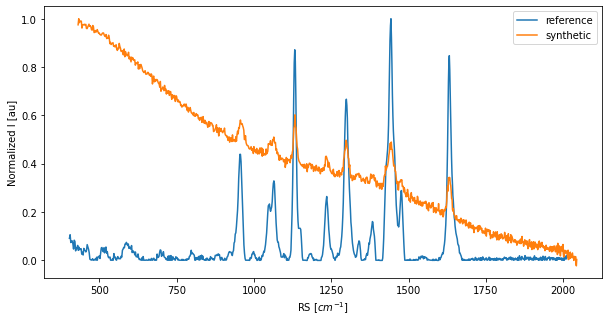

In [8]:
from orpl.synthetic import gen_synthetic_spectrum
from orpl.calibration import autogenx

# Generation of synthetic nylon spectrum
synth_nylon, _, _, _ = gen_synthetic_spectrum('nylon', rb_ratio=0.2, noise_std=0.01)

# xaxis automatic generation
xaxis = autogenx(synth_nylon, preset='nylon')

# Plotting result
plt.figure(figsize=[10,5])
plt.plot(ref_nylon_x, ref_nylon_r/ref_nylon_r.max(), label='reference')
plt.plot(xaxis, synth_nylon/synth_nylon.max(), label='synthetic')
plt.xlabel('RS [$cm^{-1}$]')
plt.ylabel('Normalized I [au]')
plt.legend()